In [4]:
%pip install pylabel pyyaml -q

In [9]:
import os
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import shutil

In [69]:
# Define the main folder path
folder_path = '/scratch/ybt7qf/ds6050-group1-project/ECP'

# Function to recursively search for JSON files
def find_json_files(directory):
    json_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

# Get a list of JSON files in subfolders
json_files = find_json_files(folder_path)

identities = set()
# Iterate over the JSON files and load their contents
for json_file in json_files:
    with open(json_file, 'r') as file:
        data = json.load(file)
        # Process the loaded JSON data here
        for item in data['children']:
            identities.add(item['identity'])

identity_mapping = {value: index for index, value in enumerate(identities)}
identity_mapping

{'wheelchair-group': 0,
 'pedestrian': 1,
 'bicycle-group': 2,
 'rider+vehicle-group-far-away': 3,
 'bicycle': 4,
 'rider': 5,
 'buggy-group': 6,
 'motorbike-group': 7,
 'motorbike': 8,
 'person-group-far-away': 9,
 'scooter-group': 10,
 'tricycle-group': 11,
 None: 12}

In [95]:
# Define the main folder path
# main_folder_path = '/scratch/ybt7qf/ds6050-group1-project/ECP/day/labels/train/'
# main_folder_path = '/scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/train/'
# main_folder_path = '/scratch/ybt7qf/ds6050-group1-project/ECP/day/labels/val/'
main_folder_path = '/scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/val/'

json_files = find_json_files(main_folder_path)

# save_dir = "/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train/"
save_dir = "/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val/"

os.makedirs(save_dir, exist_ok=True)

# Function to normalize coordinates
def normalize_coordinates(x0, y0, x1, y1, image_width, image_height):
    normalized_x0 = x0 / image_width
    normalized_y0 = y0 / image_height
    normalized_width = (x1 - x0) / image_width
    normalized_height = (y1 - y0) / image_height
    return normalized_x0, normalized_y0, normalized_width, normalized_height

# Iterate over subfolders and process JSON files
for json_file in json_files:
    # Get the base name (with extension)
    base_name = os.path.basename(json_file)

    # Get the file name without extension
    file_name_without_extension = os.path.splitext(base_name)[0]

    with open(json_file, 'r') as file:
        data = json.load(file)

    children = data.get('children', [])
    with open(save_dir+f"{file_name_without_extension}.txt", 'w') as txt_file:
        for child in children:
            identity = child.get('identity', None)
            if identity:
                identity_index = identity_mapping[identity]
                x0, y0, x1, y1 = child['x0'], child['y0'], child['x1'], child['y1']
                normalized_x0, normalized_y0, normalized_width, normalized_height = normalize_coordinates(
                    x0, y0, x1, y1, data['imagewidth'], data['imageheight']
                )

                # Save data in the text file
                txt_file.write(f"{identity_index} {normalized_x0} {normalized_y0} {normalized_width} {normalized_height}\n")
            else:
                print(f"no labels for {json_file}")
print("Processing completed.")

Processing completed.


In [102]:
# Source folder path (the folder containing subfolders)
source_folder = '/scratch/ybt7qf/ds6050-group1-project/ECP/day/img/train/'
# source_folder = '/scratch/ybt7qf/ds6050-group1-project/ECP/night/img/train/'
# source_folder = '/scratch/ybt7qf/ds6050-group1-project/ECP/day/img/val/'
# source_folder = '/scratch/ybt7qf/ds6050-group1-project/ECP/night/img/val/'


# Destination folder path (where you want to move the .png files)
destination_folder = "/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/"
# destination_folder = "/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val/"

os.makedirs(destination_folder, exist_ok=True)

# Loop over all subfolders and move .png files
for root, dirs, files in os.walk(source_folder):
    for file in files:
        if file.endswith('.png'):
            source_file = os.path.join(root, file)
            destination_file = os.path.join(destination_folder, file)

            # Create the destination folder if it doesn't exist
            os.makedirs(os.path.dirname(destination_file), exist_ok=True)

            # Copy the .png file to the destination folder
            shutil.copy(source_file, destination_file)

print("PNG files copied to the destination folder.")


PNG files copied to the destination folder.


In [80]:
# json_file = "/scratch/ybt7qf/ds6050-group1-project/ECP/night/labels/train/koeln/koeln_00321.json"
# with open(json_file, 'r') as file:
#     data = json.load(file)
# data

In [7]:
def plot_box(text_file_path, image_path):
    # Load bounding box data from the text file
    boxes = []
    with open(text_file_path, 'r') as file:
        for line in file:
            data = line.strip().split()
            identity, x0, y0, width, height = data
            x0, y0, width, height = float(x0), float(y0), float(width), float(height)
            boxes.append((identity, x0, y0, width, height))

    # Load the image
    image = Image.open(image_path)

    # Create a plot to display the image and bounding boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Plot bounding boxes on the image
    for identity, x0, y0, width, height in boxes:
        x0_unnormalized = x0 * image.width
        y0_unnormalized = y0 * image.height
        width_unnormalized = width * image.width
        height_unnormalized = height * image.height

        rect = Rectangle((x0_unnormalized, y0_unnormalized), width_unnormalized, height_unnormalized, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # ax.annotate(identity, (x0_unnormalized, y0_unnormalized), color='r', fontsize=10, backgroundcolor='w')

    # Set axis limits
    ax.set_xlim(0, image.width)
    ax.set_ylim(image.height, 0)

    # Show the image with bounding boxes
    plt.show()


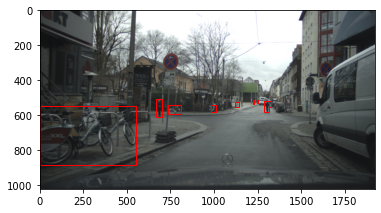

In [10]:
text_file_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train/dresden_00653.txt'  # Update with your text file path
image_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/dresden_00653.png'  # Update with your image file path
plot_box(text_file_path, image_path)

In [3]:
source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train/'
# source_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val/'

destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/'
# destination_folder = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/'

os.makedirs(destination_folder, exist_ok=True)

desired_width = 640

def resize_image(image_path):
    with Image.open(image_path) as img:
        w, h = img.size
        new_height = int((desired_width / w) * h)
        img_resized = img.resize((desired_width, new_height), Image.ANTIALIAS)
        destination_path = os.path.join(destination_folder, os.path.basename(image_path))
        img_resized.save(destination_path, quality=90)  # Adjust quality as needed

# Get a list of image files
image_files = [os.path.join(source_folder, filename) for filename in os.listdir(source_folder) if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff'))]

# Using a thread pool for concurrent resizing
with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust max_workers as needed
    list(tqdm(executor.map(resize_image, image_files), total=len(image_files), desc="Resizing images"))

print("Images resized and saved to the destination folder.")

Resizing images: 100%|██████████| 28114/28114 [21:20<00:00, 21.96it/s]

Images resized and saved to the destination folder.


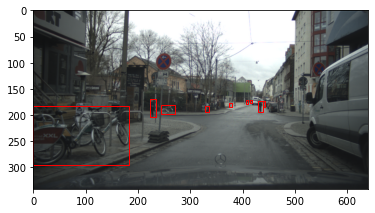

In [11]:
text_file_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/dresden_00653.txt'  # Update with your text file path
image_path = '/scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/dresden_00653.png'  # Update with your image file path
plot_box(text_file_path, image_path)

In [11]:
%%writefile /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml
path: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset
train: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize
val: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize
    
nc: 12
    
names: [
    'wheelchair-group',
    'pedestrian',
    'bicycle-group',
    'rider+vehicle-group-far-away',
    'bicycle',
    'rider',
    'buggy-group',
    'motorbike-group',
    'motorbike',
    'person-group-far-away',
    'scooter-group',
    'tricycle-group'
]

Overwriting /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml


In [12]:
!cat /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml

path: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset
train: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize
val: /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize
    
nc: 12
    
names: [
    'wheelchair-group',
    'pedestrian',
    'bicycle-group',
    'rider+vehicle-group-far-away',
    'bicycle',
    'rider',
    'buggy-group',
    'motorbike-group',
    'motorbike',
    'person-group-far-away',
    'scooter-group',
    'tricycle-group'
]


In [16]:
!python yolo-to-coco.py \
    --path_to_annotations /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/train-resize/ \
    --path_to_images /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/train-resize/ \
    --path_to_yolo_yaml /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml \
    --name eurocitypersonsdataset_train

/home/ybt7qf/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Importing YOLO files...: 100%|███████████| 28114/28114 [03:37<00:00, 129.37it/s]
                                           img_folder  ... annotated
id                                                     ...          
0   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
1   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
2   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
3   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1
4   /scratch/ybt7qf/ds6050-group1-project/datasets...  ...         1

[5 rows x 26 columns]
Number of images: 28114
Number of classes: 12
Classes: ['wheelchair-group', 'pedestrian', 'bicycle-group', 'rider+vehicle-group-far-away', 'bicycle', 'rid

In [ ]:
!python yolo-to-coco.py \
    --path_to_annotations /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/labels/val-resize/ \
    --path_to_images /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset/images/val-resize/ \
    --path_to_yolo_yaml /scratch/ybt7qf/ds6050-group1-project/datasets/eurocitypersonsdataset.yaml \
    --name eurocitypersonsdataset_val